In [17]:
import os
import requests
import tqdm.auto
import pandas as pd
import numpy as np
import joblib

import dask_ml.preprocessing
import dask.distributed

import sklearn.model_selection
import sklearn.svm
import sklearn.ensemble
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#### Download features data from s3 (if necessary)

In [18]:
dataset_url = "https://mustafa-burny-dse230-20210523.s3-us-west-2.amazonaws.com/final-project/tsfresh_relevant_features.parquet"

if not os.path.exists(os.path.basename(dataset_url)):
    response = requests.get(dataset_url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm.auto.tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(os.path.basename(dataset_url), 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        raise Exception("ERROR, something went wrong")

In [19]:
dataset_url = "https://mustafa-burny-dse230-20210523.s3-us-west-2.amazonaws.com/final-project/tsfresh_all_features.parquet"

if not os.path.exists(os.path.basename(dataset_url)):
    response = requests.get(dataset_url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm.auto.tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(os.path.basename(dataset_url), 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        raise Exception("ERROR, something went wrong")

#### Load features and labels data (from local disk)

In [20]:
# Read features data
features_df = pd.read_parquet('tsfresh_relevant_features.parquet')

# Extract label data from processed raw data
segment_labels = pd.read_parquet('processed_raw_data.parquet').reset_index()\
    .filter(items=['segment_id', 'activity_name'])\
    .drop_duplicates()\
    .set_index('segment_id')['activity_name']

# Combine features and segment lables into a single dataframe
df = pd.merge(
    left = features_df,
    right = segment_labels,
    how = 'left',
    left_index = True,
    right_index = True
)

# Convert activity name to an ordered Categorical
df['activity_name'] = pd.Categorical(
    df['activity_name'],
    categories = pd.read_parquet('processed_raw_data.parquet').reset_index()\
        .filter(items=['activity_id', 'activity_name'])\
        .drop_duplicates()\
        .sort_values('activity_id')['activity_name'].values,
    ordered = True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10809 entries, 1 to 11138
Columns: 5146 entries, accel_phone_y__variance_larger_than_standard_deviation to activity_name
dtypes: category(1), float64(5145)
memory usage: 424.6 MB


#### Start Dask Client

In [21]:
client = dask.distributed.Client()

client

Client Scheduler: tcp://127.0.0.1:52722 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.00 GiB


### Process into training and testing data

In [22]:
# Some Parameters
SEED = 42
TRAIN_SIZE = 0.25
TEST_SIZE = 0.75

# Get features and labels
X = df.iloc[:, 0:-1].copy()
y = df.iloc[:, -1].copy()

# Encode target labels as numbers
label_encoder = dask_ml.preprocessing.LabelEncoder(use_categorical=True)
label_encoder.fit(y)
y = label_encoder.transform(y)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = dask_ml.model_selection.train_test_split(
    X, y, 
    train_size = TRAIN_SIZE, 
    test_size = TEST_SIZE, 
    random_state = SEED
)

# Scale features (using training data only)
standard_scaler = dask_ml.preprocessing.StandardScaler()
standard_scaler.fit(X_train)
X_train = standard_scaler.transform(X_train).values
X_test = standard_scaler.transform(X_test).values

#### Linear Support Vector Classification (SVC)

In [23]:
param_grid = {
    'C': np.logspace(-3, 2, 25),
}

search = sklearn.model_selection.GridSearchCV(
    sklearn.svm.SVC(gamma='auto', random_state=SEED, kernel='linear', probability=True),
    param_grid = param_grid,
    return_train_score = False,
    cv = 3,
    verbose = True
)

with joblib.parallel_backend('dask'):
    # We perform the hyperparameter search using a smaller dataset
    X_train_HP, _, y_train_HP, _ = dask_ml.model_selection.train_test_split(X_train, y_train, train_size=1000, test_size=1, random_state=SEED)
    search.fit(X_train_HP, y_train_HP)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [8]:
model = search.best_estimator_.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('       Best Model: {}'.format(search.best_estimator_))
print('  Best Parameters: {}'.format(search.best_params_))
print('Training Accuracy: {:.2%}'.format(model.score(X_train, y_train)))
print(' Testing Accuracy: {:.2%}'.format(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=y_pred)))

       Best Model: SVC(C=0.003593813663804626, gamma='auto', kernel='linear', probability=True,
    random_state=42)
  Best Parameters: {'C': 0.003593813663804626}
Training Accuracy: 100.00%
 Testing Accuracy: 85.28%


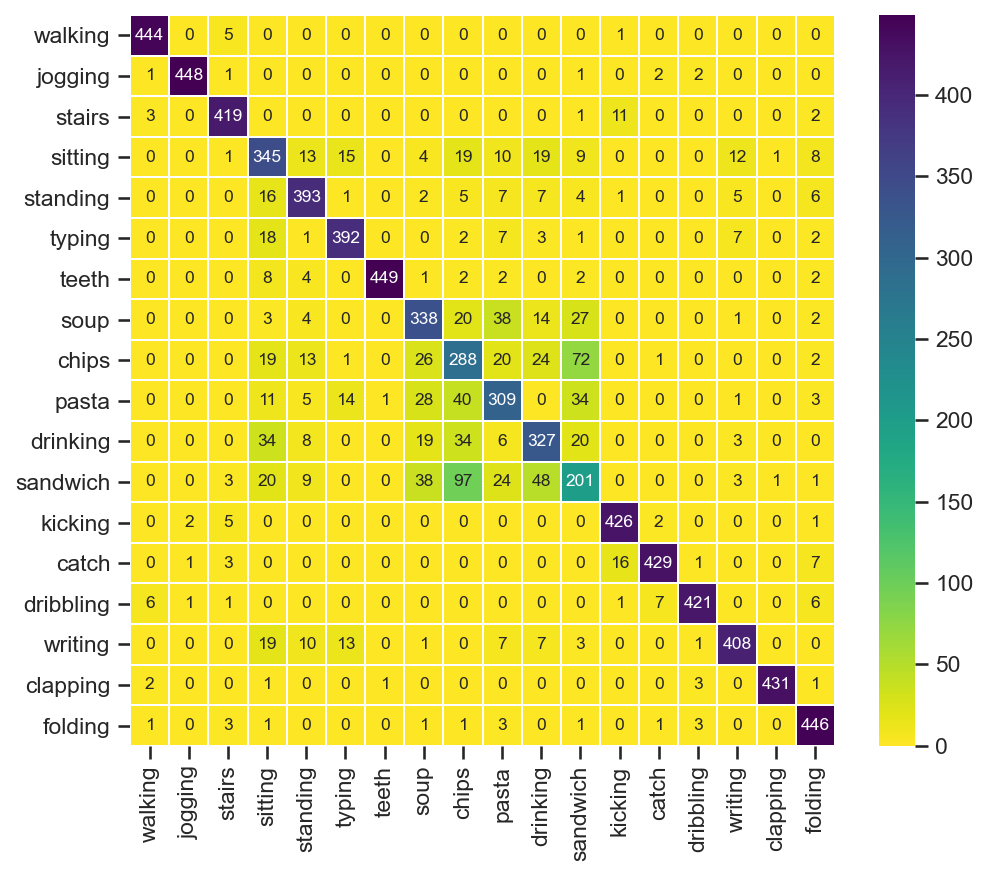

In [9]:
sns.reset_defaults()
sns.set(style='ticks')
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=150)
sns.despine()

confusion_matrix = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

sns.heatmap(
    pd.DataFrame(
        confusion_matrix, 
        index = label_encoder.classes_, 
        columns = label_encoder.classes_
    ),
    cbar = True,
    annot = True,
    fmt = 'd',
    annot_kws = {"fontsize": 'x-small'},
    linewidths = 0.1,
    cmap = 'viridis_r',
)

fig.tight_layout()
plt.close('all')

fig

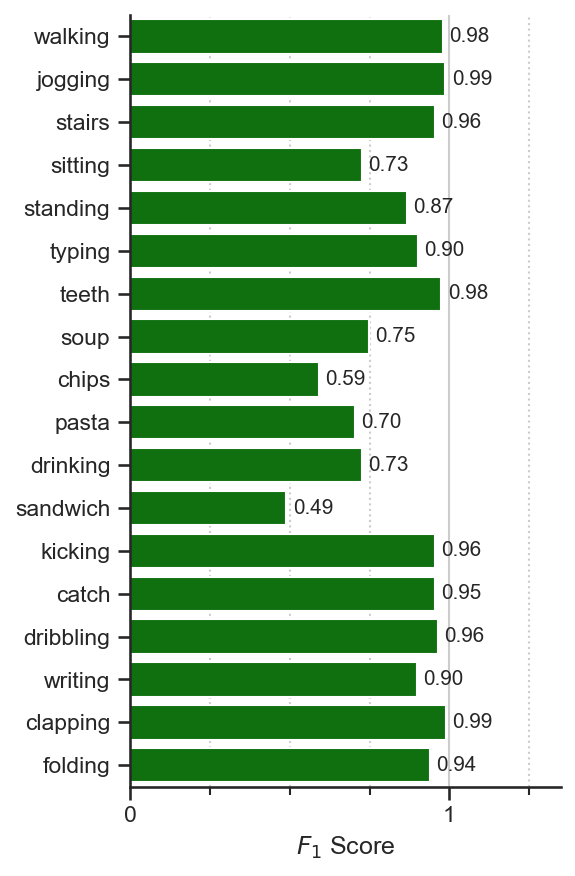

In [10]:
sns.reset_defaults()
sns.set(style='ticks')
fig, ax = plt.subplots(1, 1, figsize=(4, 6), dpi=150)
sns.despine()

graph_data = pd.DataFrame(sklearn.metrics.classification_report(
    y_test,
    y_pred,
    target_names = label_encoder.classes_,
    output_dict = True
)).T['f1-score'].iloc[0:-3]

sns.barplot(
    x = graph_data.values,
    y = graph_data.index.values,
    color = 'green'
)

for i, (label, value) in enumerate(graph_data.iteritems()):
    ax.text(value + 0.02, i, '{:.2f}'.format(value), ha='left', va='center', fontsize='small')

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.25))
ax.grid(True, which='major', axis='x', color='#cccccc', linestyle='solid')
ax.grid(True, which='minor', axis='x', color='#cccccc', linestyle='dotted')
ax.set_xlim(left=0, right=1.35)
ax.set_xlabel('$F_1$ Score')

fig.tight_layout()
plt.close('all')

fig

#### Random Forest Classifier

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2],
}

search = sklearn.model_selection.GridSearchCV(
    sklearn.ensemble.RandomForestClassifier(random_state=SEED),
    param_grid = param_grid,
    return_train_score = False,
    cv = 3,
    verbose = True
)

with joblib.parallel_backend('dask'):
    # We perform the hyperparameter search using a smaller dataset
    X_train_HP, _, y_train_HP, _ = dask_ml.model_selection.train_test_split(X_train, y_train, train_size=1000, test_size=1, random_state=SEED)
    search.fit(X_train_HP, y_train_HP)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [12]:
model = search.best_estimator_.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('       Best Model: {}'.format(search.best_estimator_))
print('  Best Parameters: {}'.format(search.best_params_))
print('Training Accuracy: {:.2%}'.format(model.score(X_train, y_train)))
print(' Testing Accuracy: {:.2%}'.format(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=y_pred)))

       Best Model: RandomForestClassifier(n_estimators=300, random_state=42)
  Best Parameters: {'max_depth': None, 'n_estimators': 300}
Training Accuracy: 100.00%
 Testing Accuracy: 86.81%


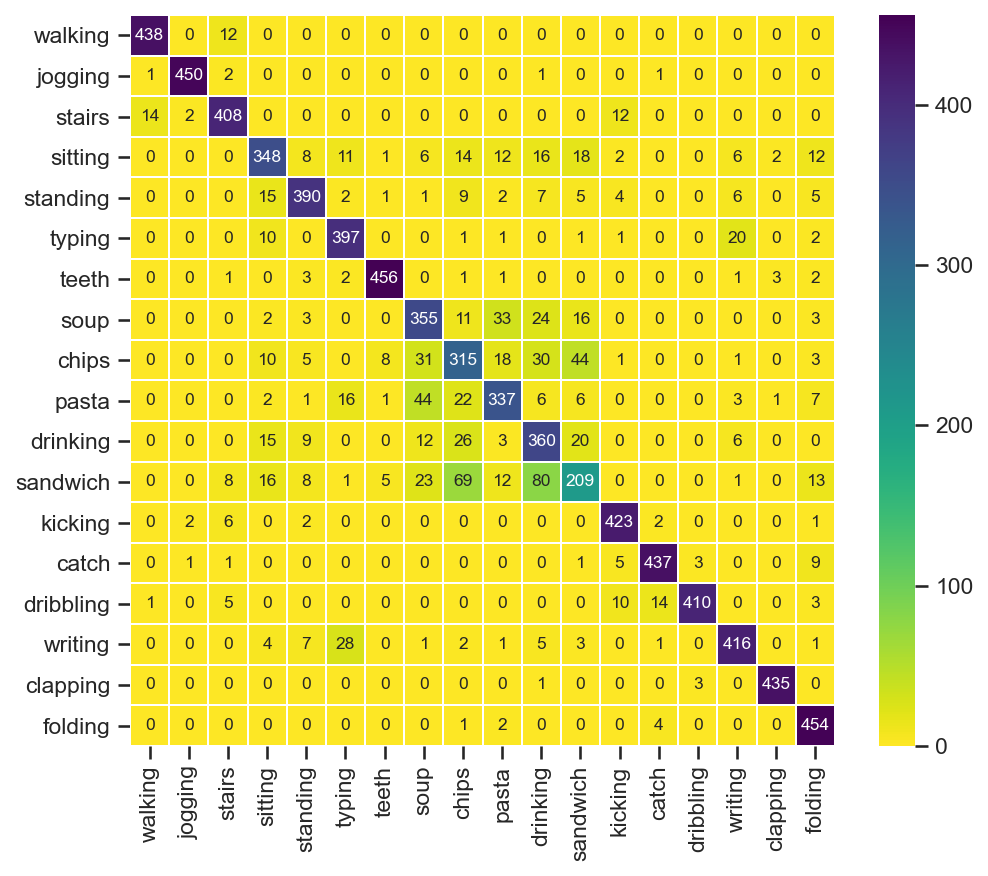

In [13]:
sns.reset_defaults()
sns.set(style='ticks')
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=150)
sns.despine()

confusion_matrix = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

sns.heatmap(
    pd.DataFrame(
        confusion_matrix, 
        index = label_encoder.classes_, 
        columns = label_encoder.classes_
    ),
    cbar = True,
    annot = True,
    fmt = 'd',
    annot_kws = {"fontsize": 'x-small'},
    linewidths = 0.1,
    cmap = 'viridis_r',
)

fig.tight_layout()
plt.close('all')

fig

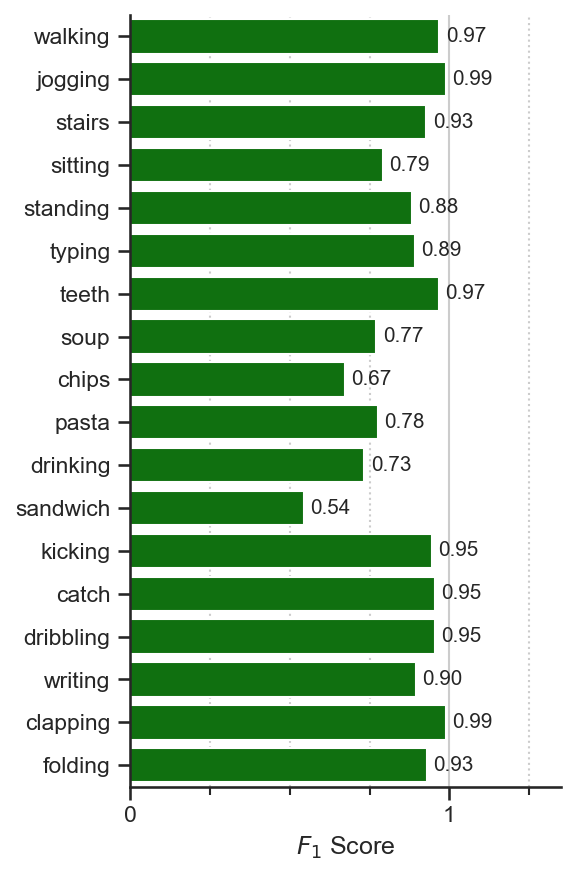

In [14]:
sns.reset_defaults()
sns.set(style='ticks')
fig, ax = plt.subplots(1, 1, figsize=(4, 6), dpi=150)
sns.despine()

graph_data = pd.DataFrame(sklearn.metrics.classification_report(
    y_test,
    y_pred,
    target_names = label_encoder.classes_,
    output_dict = True
)).T['f1-score'].iloc[0:-3]

sns.barplot(
    x = graph_data.values,
    y = graph_data.index.values,
    color = 'green'
)

for i, (label, value) in enumerate(graph_data.iteritems()):
    ax.text(value + 0.02, i, '{:.2f}'.format(value), ha='left', va='center', fontsize='small')

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.25))
ax.grid(True, which='major', axis='x', color='#cccccc', linestyle='solid')
ax.grid(True, which='minor', axis='x', color='#cccccc', linestyle='dotted')
ax.set_xlim(left=0, right=1.35)
ax.set_xlabel('$F_1$ Score')

fig.tight_layout()
plt.close('all')

fig

#### Shutdown Dask client

In [15]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
